In [ ]:
"""
How I made top 0.3% on a Kaggle competition
Getting started with competitive data science can be quite intimidating.
So I wrote this quick overview of how I made top 0.3% on the Advanced Regression 
Techniques competition. If there is interest, I’m happy to do deep dives into the intuition 
behind the feature engineering and models used in this kernel.

I encourage you to fork this kernel, play with the code and enter the competition. Good luck!

If you like this kernel, please give it an upvote. Thank you!


The Goal
1.Each row in the dataset describes the characteristics of a house.
2.Our goal is to predict the SalePrice, given these features.
3.Our models are evaluated on the Root-Mean-Squared-Error (RMSE) between 
the log of the SalePrice predicted by our model, 
and the log of the actual SalePrice. Converting RMSE errors to a log scale ensures that errors in 
predicting expensive houses and cheap houses will affect our score equally.


Key features of the model training process in this kernel:
1.Cross Validation: Using 12-fold cross-validation
2.Models: On each run of cross-validation I fit 7 models (ridge, svr, gradient boosting, random forest, xgboost, lightgbm regressors)
3.Stacking: In addition, I trained a meta StackingCVRegressor optimized using xgboost
4.Blending: All models trained will overfit the training data to varying degrees. Therefore, to make final predictions, I blended their predictions together to get more robust predictions.

Model Performance
1. We can observe from the graph below that the blended model far outperforms the other models, with an RMSLE of 0.075. This is the model I used for making the final predictions.

"""

In [1]:
from IPython.display import Image
import seaborn as sns

In [2]:
from mlxtend.regressor import StackingCVRegressor
%matplotlib inline 
# 使matplot可以在jupyter中显示 

In [3]:
# Essentials
import numpy as np
import pandas as pd
import datetime
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax



D:\Users\kexin\Anaconda2\envs\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [5]:
# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)



In [6]:
# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
# 设定pandas的选项
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

import os
print(os.listdir("./input"))

['house-prices-advanced-regression-techniques']


In [87]:
# Read in the dataset as a dataframe
train = pd.read_csv('input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('input/house-prices-advanced-regression-techniques/test.csv')
train.shape, test.shape

((1460, 81), (1459, 80))

In [8]:
!ls input/house-prices-advanced-regression-techniques

data_description.txt
sample_submission.csv
test.csv
train.csv


In [9]:
# Preview the data we're working with
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


In [11]:
# 可以看到,pandas加载的列的类型只有int64与object两种类型 

In [12]:
sns.distplot?

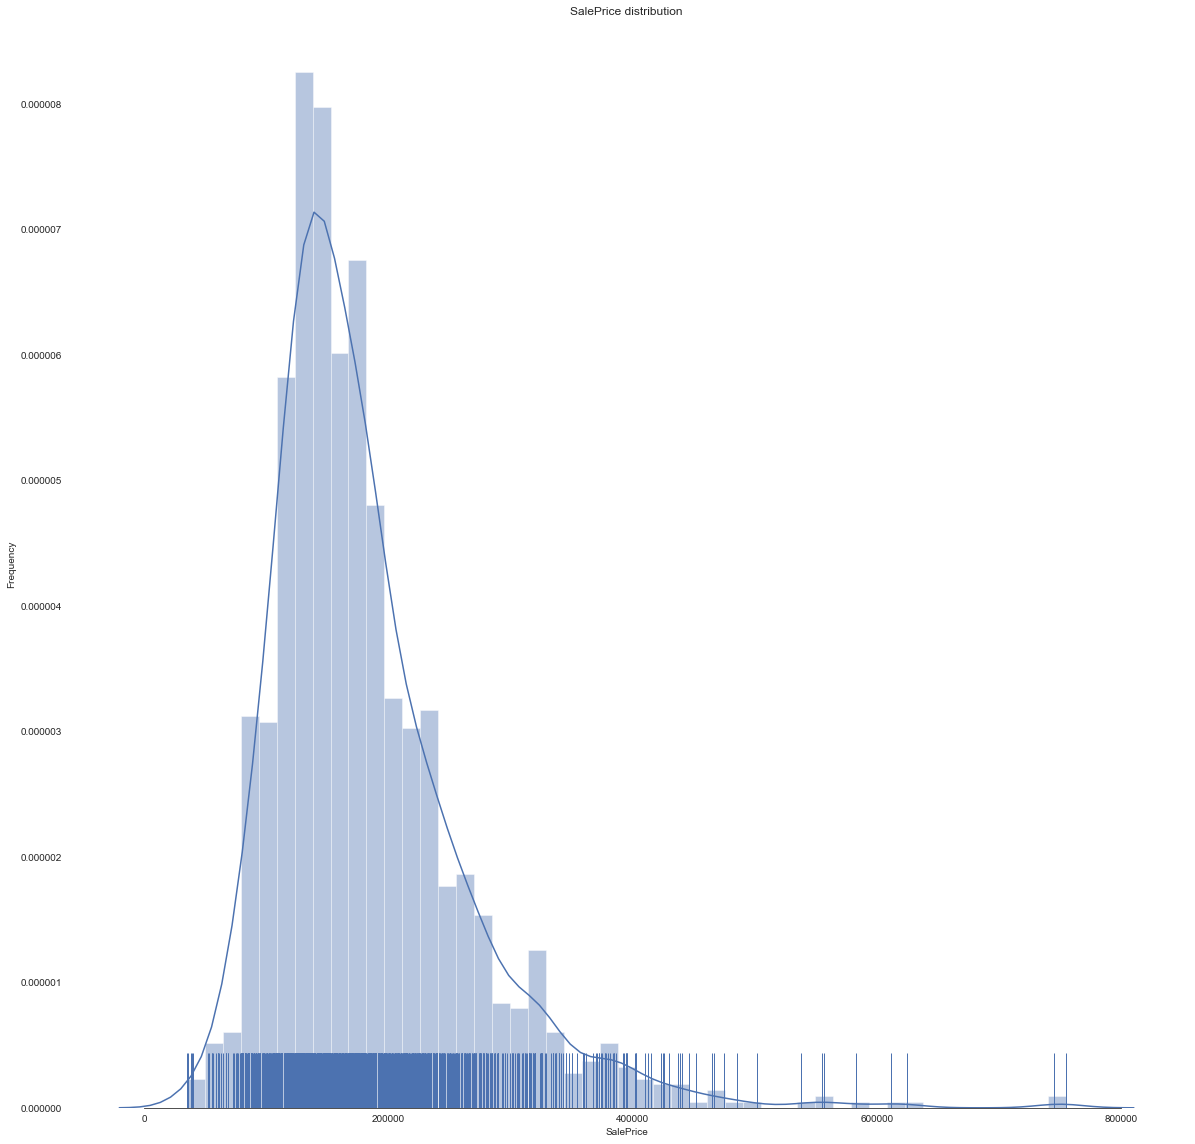

In [24]:
# SalePrice: the variable we're trying to predict¶
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(20, 20))
#Check the new distribution 
sns.distplot(train['SalePrice'], color="b", hist=True, kde=True, rug=True) # kde=True,默认为估计概率密度函数
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)

In [26]:
# Skew and kurt
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


In [28]:
# Let's visualize some of the features in the dataset
# Finding numeric features
# 找出所有的数值类型
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in train.columns:
    if train[i].dtype in numeric_dtypes: # 必须为数值类型 
        if i in ['TotalSF', 'Total_Bathrooms','Total_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
            pass
        else:
            numeric.append(i)       


[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.8087954113106306, 0.5634700050056693, 0.19502642696727285),
 (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (0.19783576093349015, 0.6955516966063037, 0.3995301037444499),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.22335772267769388, 0.6565792317435265, 0.8171355503265633),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 (0.9603888539940703, 0.3814317878772117, 0.8683117650835491)]

In [29]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [30]:
[(col, train[col].dtype ) for col in numeric]

[('Id', dtype('int64')),
 ('MSSubClass', dtype('int64')),
 ('LotFrontage', dtype('float64')),
 ('LotArea', dtype('int64')),
 ('OverallQual', dtype('int64')),
 ('OverallCond', dtype('int64')),
 ('YearBuilt', dtype('int64')),
 ('YearRemodAdd', dtype('int64')),
 ('MasVnrArea', dtype('float64')),
 ('BsmtFinSF1', dtype('int64')),
 ('BsmtFinSF2', dtype('int64')),
 ('BsmtUnfSF', dtype('int64')),
 ('TotalBsmtSF', dtype('int64')),
 ('1stFlrSF', dtype('int64')),
 ('2ndFlrSF', dtype('int64')),
 ('LowQualFinSF', dtype('int64')),
 ('GrLivArea', dtype('int64')),
 ('BsmtFullBath', dtype('int64')),
 ('BsmtHalfBath', dtype('int64')),
 ('FullBath', dtype('int64')),
 ('HalfBath', dtype('int64')),
 ('BedroomAbvGr', dtype('int64')),
 ('KitchenAbvGr', dtype('int64')),
 ('TotRmsAbvGrd', dtype('int64')),
 ('Fireplaces', dtype('int64')),
 ('GarageYrBlt', dtype('float64')),
 ('GarageCars', dtype('int64')),
 ('GarageArea', dtype('int64')),
 ('WoodDeckSF', dtype('int64')),
 ('OpenPorchSF', dtype('int64')),
 ('Enc

In [33]:
numeric

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

In [37]:
train[numeric].head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000


In [38]:
list(train[numeric]) # 是获取DataFrame的所有列

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

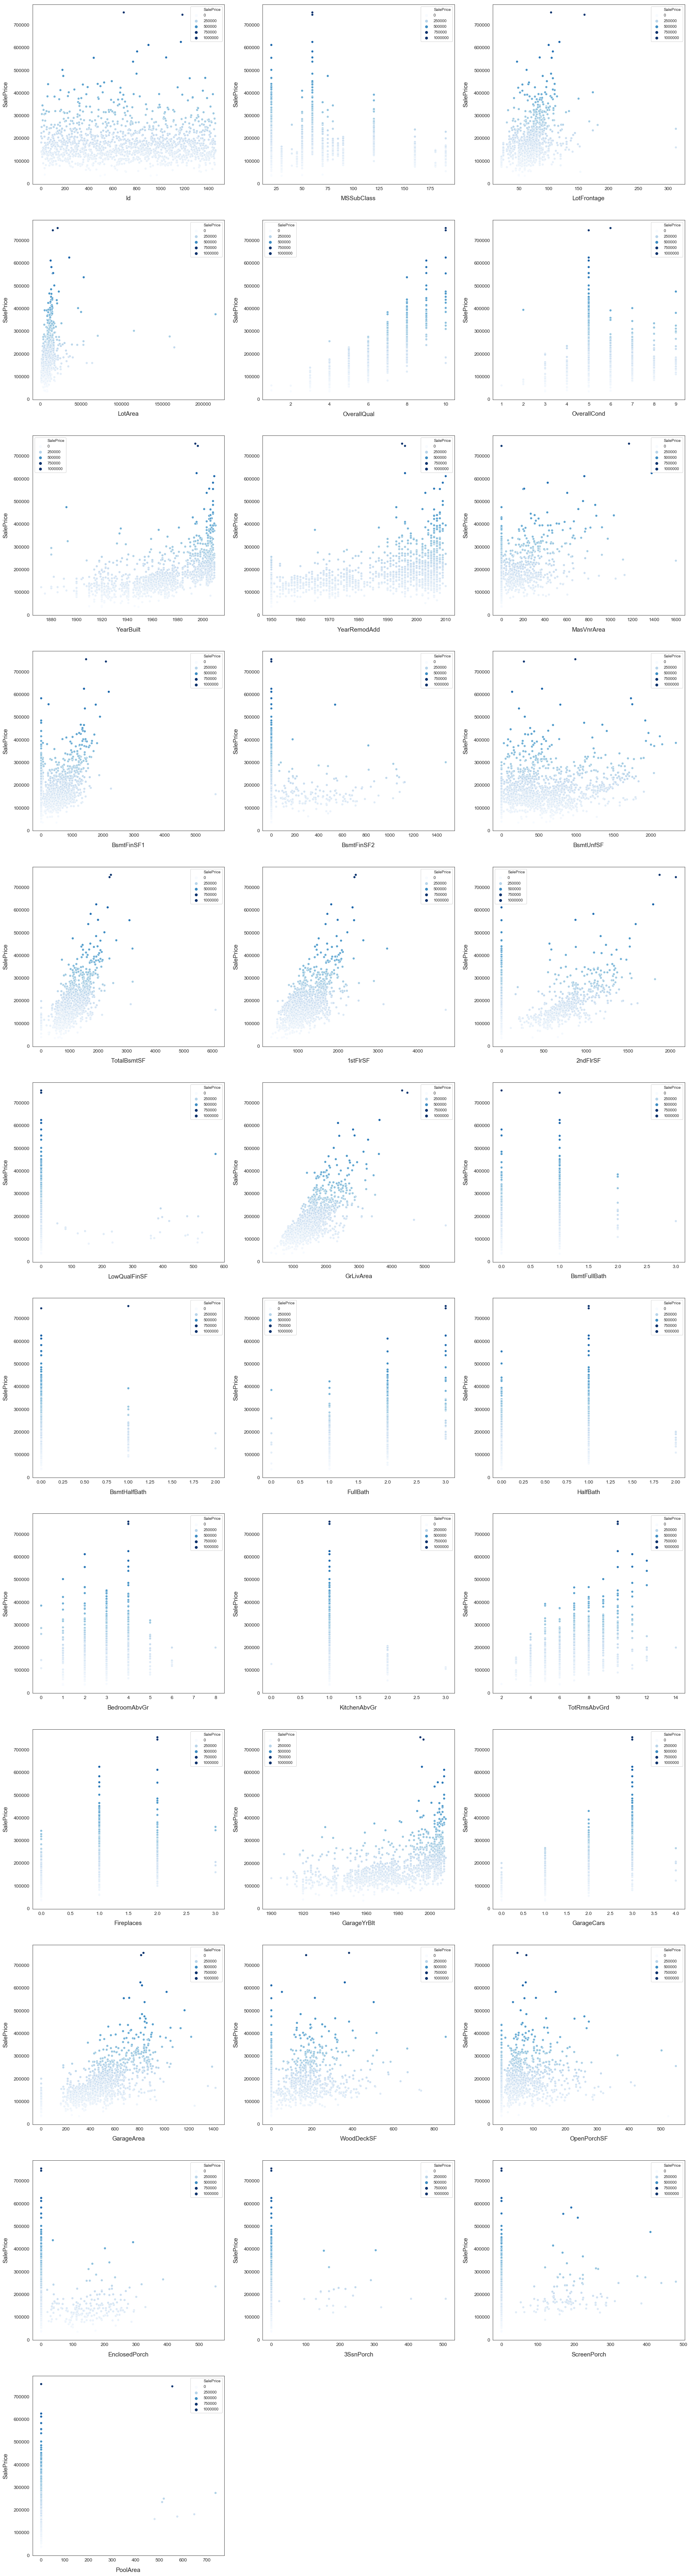

In [45]:
# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 150))
plt.subplots_adjust(right=2) # adjust不可省略,否则各个图片之间会重叠在一起
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)
for i, feature in enumerate(list(train[numeric]), 1):
    if(feature=='MiscVal'):
        break
    plt.subplot(len(list(numeric)), 3, i)
    # 画出所有的数值feature与SalePrice之间的关系
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Blues', data=train)
        
    plt.xlabel('{}'.format(feature), size=15, labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5) # 
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})  # 标题
        
plt.show()


In [47]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [48]:
train.corr?

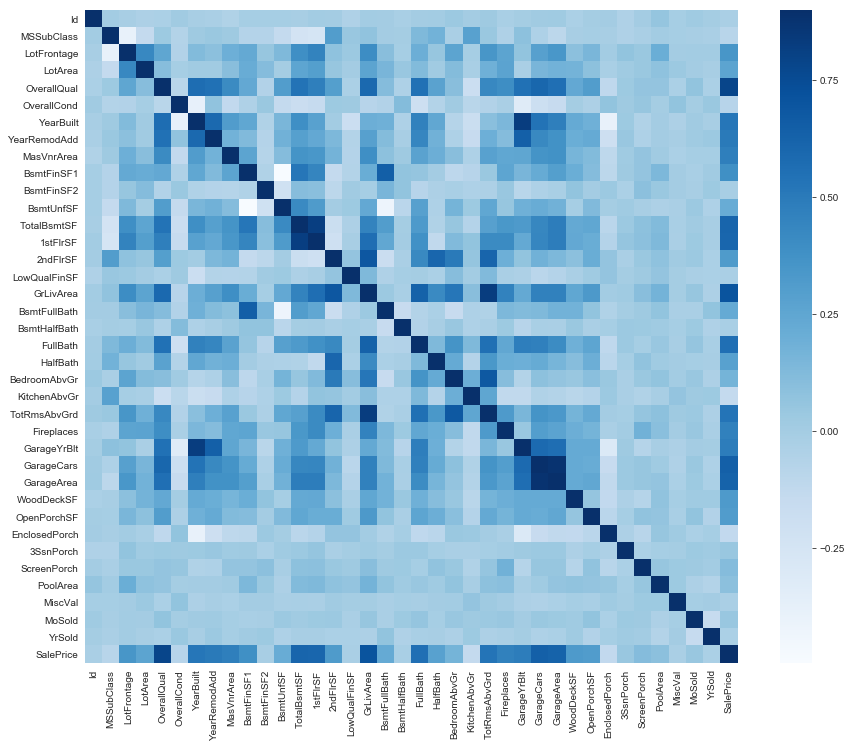

In [58]:
# and plot how the features are correlated to each other, and to SalePrice
corr = train.corr() # 计算 pearson相关系数,只包括数值特征, Compute pairwise correlation of columns, excluding NA/null values
# 不过在图中,并没有看到类别特征 Alley,lotShape, landContour
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

In [62]:
# Let's plot how SalePrice relates to some of the features in the dataset
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
data.head()

,SalePrice,OverallQual
0,208500,7
1,181500,6
2,223500,7
3,140000,7
4,250000,8


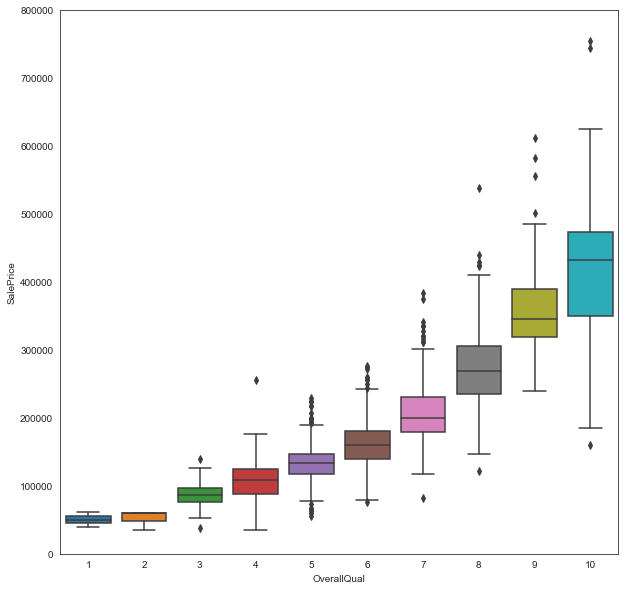

In [63]:
# 对于类别型 的数据,使用 boxplot 
# 画出装修材料与价格这间的关系
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(10, 10))
fig = sns.boxplot(x=train['OverallQual'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

In [57]:
?sns.boxplot

In [ ]:
%matplotlib inline

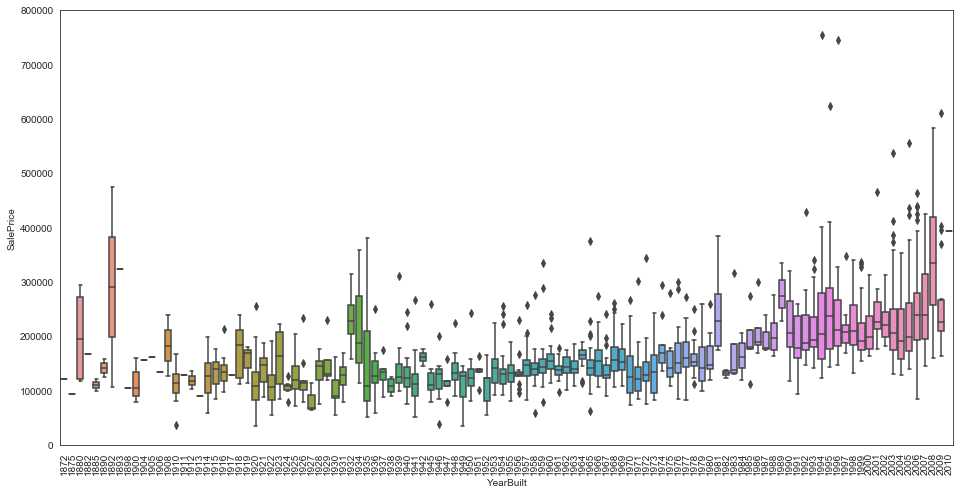

In [67]:
# YearBuilt,修建时间与价格之间的关系
data = pd.concat([train['SalePrice'], train['YearBuilt']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=train['YearBuilt'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

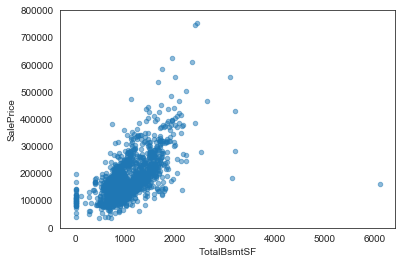

In [71]:
# Total square feet of basement area, 对于数值类型 ,画出散点图
data = pd.concat([train['SalePrice'], train['TotalBsmtSF']], axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice', alpha=0.5, ylim=(0,800000));

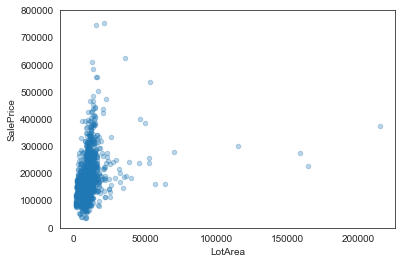

In [72]:
#  Lot size in square feet
data = pd.concat([train['SalePrice'], train['LotArea']], axis=1)
data.plot.scatter(x='LotArea', y='SalePrice', alpha=0.3, ylim=(0,800000));

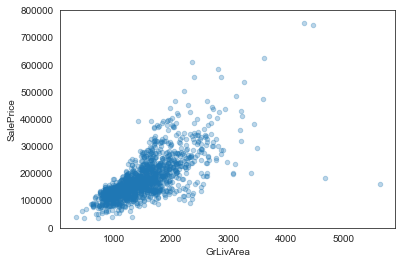

In [73]:
#  Above grade (ground) living area square feet
data = pd.concat([train['SalePrice'], train['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', alpha=0.3, ylim=(0,800000));

In [77]:
train_ID = train['Id']
train_ID.head()

pandas.core.series.Series

In [78]:
type(train_ID)

pandas.core.series.Series

In [79]:
# Remove the Ids from train and test, as they are unique for each row and hence not useful for the model
train_ID = train['Id']
test_ID = test['Id']
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)
train.shape, test.shape

((1460, 80), (1459, 79))

In [80]:
"""
Feature Engineering
Let's take a look at the distribution of the SalePrice.
"""

"\nFeature Engineering\nLet's take a look at the distribution of the SalePrice.\n"

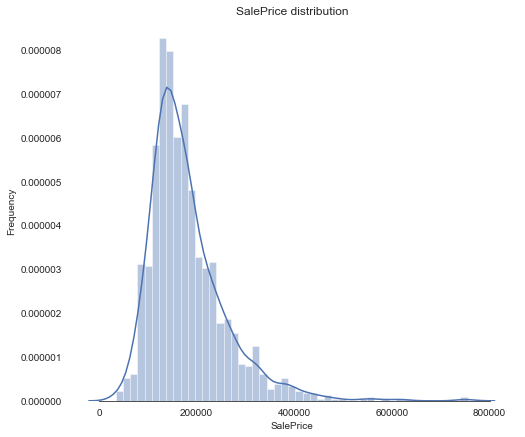

In [89]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'], color="b");  # 画出分布直方图以及概率密度拟合图
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()  # 可以发现,图像有一定的斜度,并非正态分布

In [90]:
"""
The SalePrice is skewed to the right. This is a problem because most ML models 
don't do well with non-normally distributed data. We can apply a log(1+x) tranform to fix the skew.
"""

"\nThe SalePrice is skewed to the right. This is a problem because most ML models \ndon't do well with non-normally distributed data. We can apply a log(1+x) tranform to fix the skew.\n"

In [93]:
train["SalePrice_bak"] = train["SalePrice"]
train["SalePrice_sqrt"] = np.sqrt(train["SalePrice"])

In [101]:
# log(1+x) transform
train["SalePrice_log"] = np.log1p(train["SalePrice"])

In [103]:
def plot_dist_with_sale(data:pd.core.series.Series, title=""):
    # Let's plot the SalePrice again.
    sns.set_style("white")
    sns.set_color_codes(palette='deep')
    f, ax = plt.subplots(figsize=(8, 7))
    #Check the new distribution 
    sns.distplot(data , fit=norm, color="b");

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)  # 计算最优的均值以及方差
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    ax.xaxis.grid(False)
    ax.set(ylabel="Frequency")
    ax.set(xlabel="SalePrice")
    ax.set(title=title)
    sns.despine(trim=True, left=True)
    plt.show()


 mu = 180921.20 and sigma = 79415.29



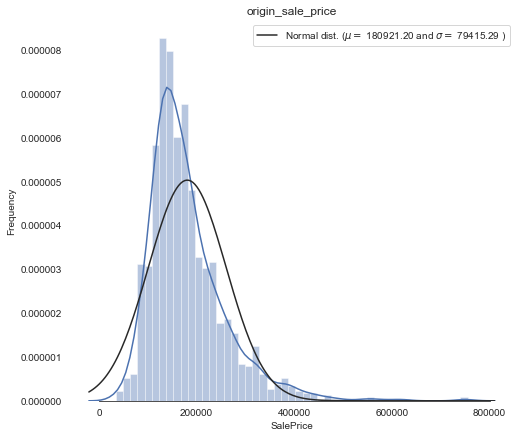

In [104]:
plot_dist_with_sale(train["SalePrice_bak"] , "origin_sale_price")


 mu = 416.62 and sigma = 85.74



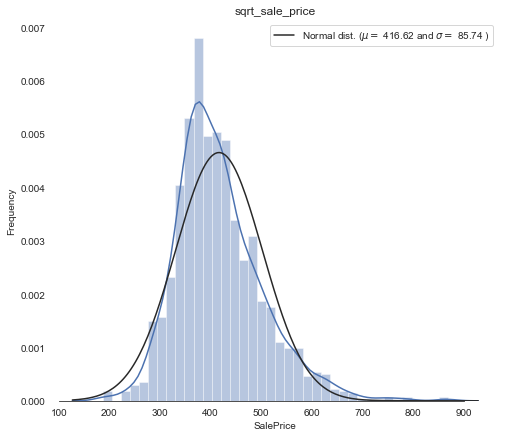

In [106]:
plot_dist_with_sale(train["SalePrice_sqrt"] , "sqrt_sale_price")  # sqrt以及log均可使数据分布成为正态分布


 mu = 12.02 and sigma = 0.40



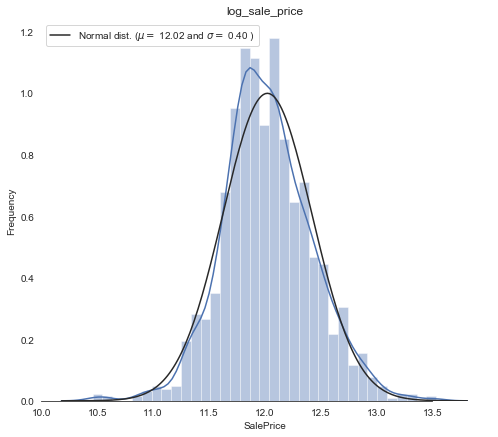

In [108]:
plot_dist_with_sale(train["SalePrice_log"] , "log_sale_price") # log变换后的正态分布最好,因此使用log变换


 mu = 12.02 and sigma = 0.40



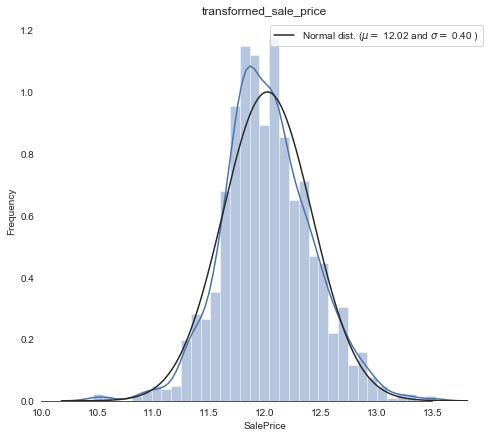

In [112]:
train["SalePrice"] = np.log1p(train["SalePrice_bak"])
# The SalePrice is now normally distributed, excellent!
plot_dist_with_sale(train["SalePrice"] , "transformed_sale_price") 
train_sale_price_bak = np.copy(train["SalePrice_bak"])

In [116]:
#train.drop(["SalePrice_bak"], inplace=True)
train_sale_price_bak

array([208500, 181500, 223500, ..., 266500, 142125, 147500], dtype=int64)

In [120]:
# Remove outliers
# 通过以上图的分析,将一些离群点移除,比如: OverallQual - SalePrice图中的离群点
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True) 
# GrLivArea- SalePrice图中右下角的点移除
train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace=True)
train.reset_index(drop=True, inplace=True) # 移除部分数据之后,重新计算 新的index

In [121]:
train['SalePrice']

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
5       11.870607
6       12.634606
7       12.206078
8       11.774528
9       11.678448
10      11.771444
11      12.751303
12      11.877576
13      12.540761
14      11.964007
15      11.790565
16      11.911708
17      11.407576
18      11.976666
19      11.842236
20      12.692506
21      11.845110
22      12.345839
23      11.774528
24      11.944714
25      12.454108
26      11.811555
27      12.631344
28      12.242891
29      11.134604
30      10.596660
31      11.914055
32      12.100162
33      12.016733
34      12.533580
35      12.641100
36      11.884496
37      11.938200
38      11.599112
39      11.314487
40      11.982935
41      12.043560
42      11.877576
43      11.777219
44      11.856522
45      12.675767
46      12.387089
47      12.428019
48      11.635152
49      11.751950
50      12.083911
51      11.648339
52      11.608245
53      12.861001
54      11.775297
55      12

In [123]:
train_labels = train['SalePrice'].reset_index(drop=True)
train_labels

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
5       11.870607
6       12.634606
7       12.206078
8       11.774528
9       11.678448
10      11.771444
11      12.751303
12      11.877576
13      12.540761
14      11.964007
15      11.790565
16      11.911708
17      11.407576
18      11.976666
19      11.842236
20      12.692506
21      11.845110
22      12.345839
23      11.774528
24      11.944714
25      12.454108
26      11.811555
27      12.631344
28      12.242891
29      11.134604
30      10.596660
31      11.914055
32      12.100162
33      12.016733
34      12.533580
35      12.641100
36      11.884496
37      11.938200
38      11.599112
39      11.314487
40      11.982935
41      12.043560
42      11.877576
43      11.777219
44      11.856522
45      12.675767
46      12.387089
47      12.428019
48      11.635152
49      11.751950
50      12.083911
51      11.648339
52      11.608245
53      12.861001
54      11.775297
55      12

In [124]:
# Split features and labels
train_labels = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

(2917, 83)

In [125]:
train_features.shape, test_features.shape

((1458, 83), (1459, 80))

In [134]:
train_features.drop(["SalePrice_bak", "SalePrice_sqrt","SalePrice_log"], inplace=True, axis=1)

In [135]:
list(train_features)

['Id',
 'MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF'

In [136]:
list(test_features)

['Id',
 'MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF'

In [132]:
# Fill missing values

In [137]:
len(list(train_features))

80

In [139]:
type(train_features)

pandas.core.frame.DataFrame

In [142]:
all_features["PoolQC"].isnull().mean()

0.9969146383270483

In [217]:
all_features["LotFrontage"].isnull().head()

0    False
1    False
2    False
3    False
4    False
Name: LotFrontage, dtype: bool

In [218]:
all_features.shape

(2917, 98)

In [149]:
all_features["LotFrontage"].ix[0],  all_features["LotFrontage"].dtypes

(65.0, dtype('float64'))

In [140]:
# determine the threshold for missing values
def percent_missing(df : pd.core.frame.DataFrame):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))  #获取所有的列的list
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return dict_x

missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('PoolQC', 99.69),
 ('MiscFeature', 96.4),
 ('Alley', 93.21),
 ('Fence', 80.43),
 ('SalePrice_bak', 50.02),
 ('SalePrice_log', 50.02),
 ('SalePrice_sqrt', 50.02),
 ('FireplaceQu', 48.68),
 ('LotFrontage', 16.66),
 ('GarageCond', 5.45)]

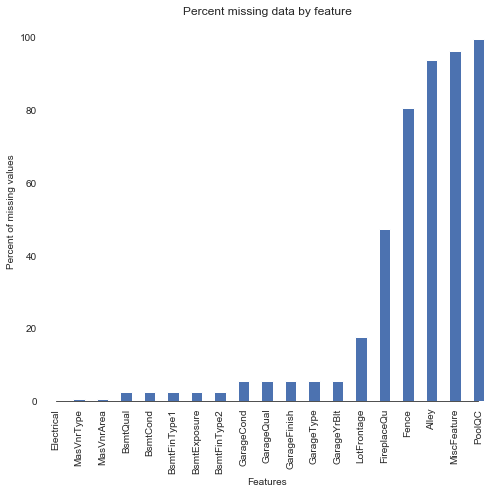

In [150]:
# Visualize missing values
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
sns.set_color_codes(palette='deep')
missing = round(train.isnull().mean()*100,2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color="b") # 画出柱状图
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature")
sns.despine(trim=True, left=True)

In [151]:
"""
We can now move through each of the features above and impute the missing values for each of them.
"""

'\nWe can now move through each of the features above and impute the missing values for each of them.\n'

In [153]:
# Some of the non-numeric predictors are stored as numbers; convert them into strings 
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)  # 将 这种类别属性转换成 str类型
all_features['YrSold'] = all_features['YrSold'].astype(str)  # 年份也要转换
all_features['MoSold'] = all_features['MoSold'].astype(str) # 月份

In [161]:
all_features['Exterior1st'].head()

0    VinylSd
1    MetalSd
2    VinylSd
3    Wd Sdng
4    VinylSd
Name: Exterior1st, dtype: object

In [163]:
all_features['Exterior1st'].mode()[0] # mode,是众数的意思,就是出现最多的那个值

'VinylSd'

In [189]:
pd.DataFrame(all_features.groupby('MSSubClass')['MSZoning'].transform(lambda x:x)).head()

,MSZoning
0,RL
1,RL
2,RL
3,RL
4,RL


In [188]:
pd.DataFrame(all_features.groupby('MSSubClass')['MSZoning'].transform(lambda x:x.mode()[0])).head()

,MSZoning
0,RL
1,RL
2,RL
3,RM
4,RL


In [187]:
two_col_head=all_features.ix[:, ["MSSubClass","MSZoning"]].ix[0:5,:]
two_col_head.ix[0,:]=[60, "RM"]
two_col_head.ix[1,:]=[60, "RM"]
two_col_head.ix[2,:]=[60, "RL"]
two_col_head.ix[3,:]=[70, "RL"]
two_col_head.ix[4,:]=[70, "RL"]
two_col_head.ix[5,:]=[70, "RM"]
two_col_head

,MSSubClass,MSZoning
0,60,RM
1,60,RM
2,60,RL
3,70,RL
4,70,RL
5,70,RM


In [190]:
pd.DataFrame(two_col_head.groupby('MSSubClass')['MSZoning'].transform(lambda x:x.mode()[0]))

,MSZoning
0,RM
1,RM
2,RM
3,RL
4,RL
5,RL


In [164]:
# 之所以 要处理nan类型 ,就是因为我们不想丢弃这些样本
def handle_missing(features):
    # the data description states that NA refers to typical ('Typ') values
    features['Functional'] = features['Functional'].fillna('Typ')
    # Replace the missing values in each of the columns below with their mode
    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0]) # 默认值给众数也是不错的选择
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    # 按类别 MSSubClass聚合后, 选取MSZonging的众数,
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0])) 
    
    # the data description stats that NA refers to "No Pool"
    features["PoolQC"] = features["PoolQC"].fillna("None")
    # Replacing the missing values with 0, since no garage = no cars in garage
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
    # Replacing the missing values with None
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
    # NaN values for these categorical basement features, means there's no basement
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')
        
    # Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # We have no particular intuition around how to fill in the rest of the categorical features
    # So we replace their missing values with None
    objects = []
    for i in features.columns:
        if features[i].dtype == object:# str 类型 
            objects.append(i)
    features.update(features[objects].fillna('None'))
        
    # And we do the same thing for numerical features, but this time with 0s
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))    
    return features

all_features = handle_missing(all_features)

In [191]:
# Let's make sure we handled all the missing values
missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('1stFlrSF', 0.0),
 ('2ndFlrSF', 0.0),
 ('3SsnPorch', 0.0),
 ('Alley', 0.0),
 ('BedroomAbvGr', 0.0),
 ('BldgType', 0.0),
 ('BsmtCond', 0.0),
 ('BsmtExposure', 0.0),
 ('BsmtFinSF1', 0.0),
 ('BsmtFinSF2', 0.0)]

In [192]:
# There are no missing values anymore!
# Fix skewed features

In [193]:
# Fetch all numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numeric.append(i)

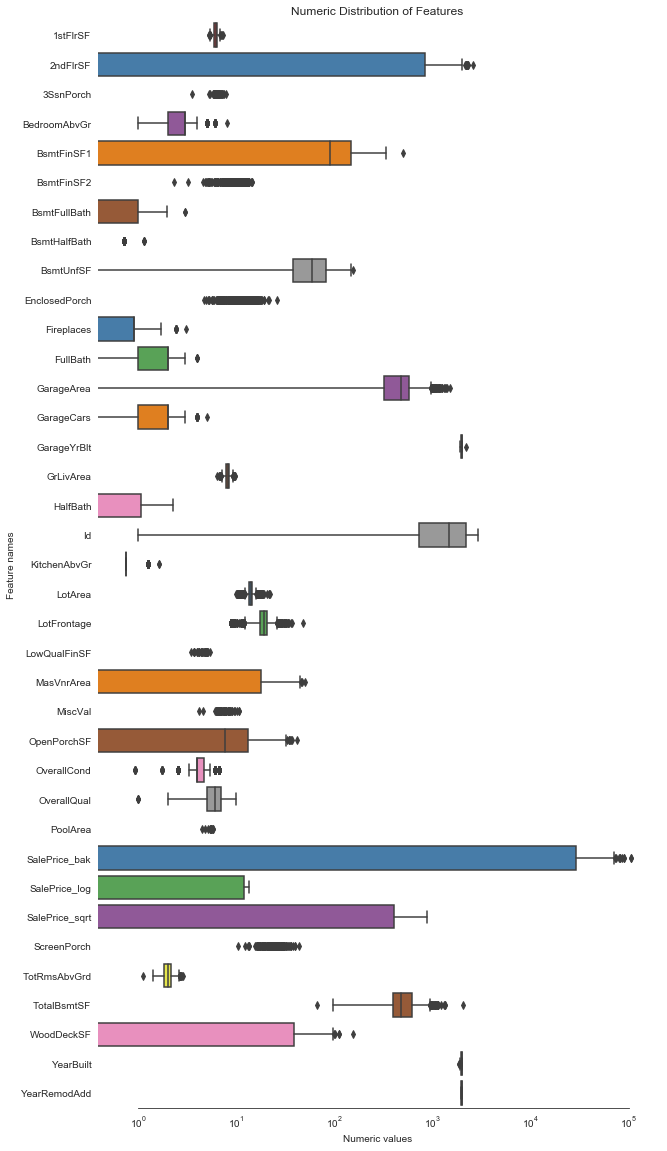

In [202]:
# Create box plots for all numeric features
sns.set_style("white")
f, ax = plt.subplots(figsize=(10, 20))
ax.set_xscale("log")  # 横轴是log 后的
ax = sns.boxplot(data=all_features[numeric] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [195]:
# Find skewed numerical features
skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 26 numerical features with Skew > 0.5 :


MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
dtype: float64

In [196]:
#We use the scipy function boxcox1p which computes the Box-Cox transformation. 
#The goal is to find a simple transformation that lets us normalize data.

In [201]:
boxcox_normmax?

In [199]:
boxcox1p?

In [197]:
# Normalize skewed features
# 将这些倾斜的数据通过box-cox转换为为近正态变量
for i in skew_index:
    all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1)) # 计算 1+x 的boxcox变换

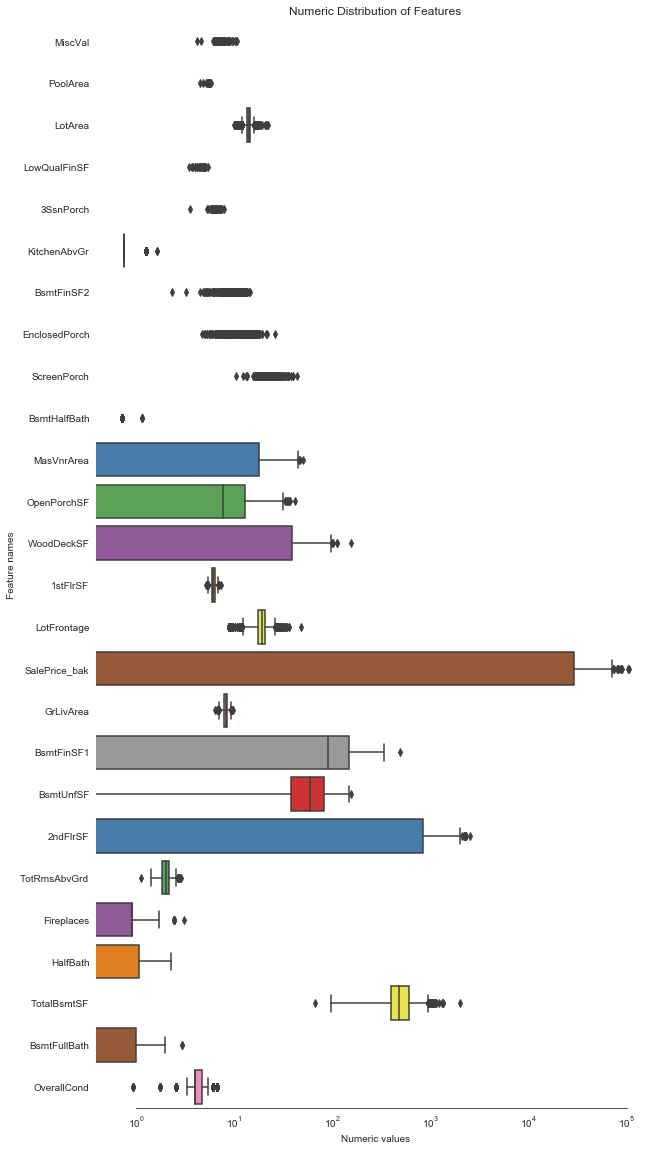

In [203]:
# Let's make sure we handled all the skewed values
sns.set_style("white")
f, ax = plt.subplots(figsize=(10, 20))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[skew_index] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [206]:
#  查看变换后的斜度变化
# 将斜度>0.5的特征选出来
skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)
# 可以看出,变换后,值的斜度大大减少

There are 17 numerical features with Skew > 0.5 :


PoolArea         15.595057
3SsnPorch         8.862045
LowQualFinSF      8.492615
MiscVal           5.237983
BsmtHalfBath      3.779434
KitchenAbvGr      3.778336
ScreenPorch       3.152631
BsmtFinSF2        2.578329
EnclosedPorch     2.149132
MasVnrArea        0.977618
dtype: float64

In [210]:
"""
All the features look fairly normally distributed now.

加入人工设计的特征

Create interesting features
ML models have trouble recognizing more complex patterns 
(and we're staying away from neural nets for this competition), 
so let's help our models out by creating a few features based on our intuition about the dataset,
e.g. total area of floors, bathrooms and porch area of each house.

"""

"\nAll the features look fairly normally distributed now.\n\n加入人工设计的特征\n\nCreate interesting features\nML models have trouble recognizing more complex patterns \n(and we're staying away from neural nets for this competition), \nso let's help our models out by creating a few features based on our intuition about the dataset,\ne.g. total area of floors, bathrooms and porch area of each house.\n\n"

In [212]:
all_features['ScreenPorch'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: ScreenPorch, dtype: float64

In [211]:
all_features['BsmtFinType1_Unf'] = 1*(all_features['BsmtFinType1'] == 'Unf')
all_features['HasWoodDeck'] = (all_features['WoodDeckSF'] == 0) * 1
all_features['HasOpenPorch'] = (all_features['OpenPorchSF'] == 0) * 1
all_features['HasEnclosedPorch'] = (all_features['EnclosedPorch'] == 0) * 1
all_features['Has3SsnPorch'] = (all_features['3SsnPorch'] == 0) * 1
all_features['HasScreenPorch'] = (all_features['ScreenPorch'] == 0) * 1
#将绝对年份转换为相对年份
all_features['YearsSinceRemodel'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)
all_features['Total_Home_Quality'] = all_features['OverallQual'] + all_features['OverallCond']
all_features = all_features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
all_features['TotalSF'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
all_features['YrBltAndRemod'] = all_features['YearBuilt'] + all_features['YearRemodAdd']

all_features['Total_sqr_footage'] = (all_features['BsmtFinSF1'] + all_features['BsmtFinSF2'] +
                                 all_features['1stFlrSF'] + all_features['2ndFlrSF'])
all_features['Total_Bathrooms'] = (all_features['FullBath'] + (0.5 * all_features['HalfBath']) +
                               all_features['BsmtFullBath'] + (0.5 * all_features['BsmtHalfBath']))
all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] + all_features['3SsnPorch'] +
                              all_features['EnclosedPorch'] + all_features['ScreenPorch'] +
                              all_features['WoodDeckSF'])

# 负数转为 较小的正数, 有些数据为错误 ,需要将其修正,如面积不可能为负数
all_features['TotalBsmtSF'] = all_features['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['2ndFlrSF'] = all_features['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
all_features['GarageArea'] = all_features['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['GarageCars'] = all_features['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
all_features['LotFrontage'] = all_features['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
all_features['MasVnrArea'] = all_features['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
all_features['BsmtFinSF1'] = all_features['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)

all_features['haspool'] = all_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['has2ndfloor'] = all_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasgarage'] = all_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasbsmt'] = all_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasfireplace'] = all_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [215]:
"""
Feature transformations

Let's create more features by calculating the log and square transformations of our numerical features.
We do this manually, because ML models won't be able to reliably tell if log(feature) or feature^2
is a predictor of the SalePrice.
"""

"\nFeature transformations\n\nLet's create more features by calculating the log and square transformations of our numerical features.\nWe do this manually, because ML models won't be able to reliably tell if log(feature) or feature^2\nis a predictor of the SalePrice.\n"

In [219]:
type(all_features)

pandas.core.frame.DataFrame

In [229]:
def logs(res:pd.core.frame.DataFrame, col_names:list):
    m = res.shape[1]
    for col in col_names:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[col])).values)  # 给dataFrame添加人工特征新列
        res.columns.values[m] = col + '_log'
        m += 1 # 此处m有更新
    return res

log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

all_features = logs(all_features, log_features)

In [230]:
all_features.shape

(2917, 248)

In [226]:
all_features.columns

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st',
       'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'Id', 'KitchenAbvGr',
       'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig',
       'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning',
       'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold',
       'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolArea', 'Ro

In [241]:
def squares(res:pd.core.frame.DataFrame, ls:list):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        res.columns.values[m] = l + '_sq'  #添加平方项
        m += 1
    return res 

squared_features = ['YearRemodAdd', 'LotFrontage_log', 
              'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
              'GarageCars_log', 'GarageArea_log']
all_features = squares(all_features, squared_features)

In [242]:
"""
Encode categorical features
Numerically encode categorical features because most models can only handle numerical features.
"""

'\nEncode categorical features\nNumerically encode categorical features because most models can only handle numerical features.\n'

In [243]:
# 将类别特征转换成数字变量(数值特征不会转换)
all_features = pd.get_dummies(all_features).reset_index(drop=True)
all_features.shape

(2917, 382)

In [236]:
pd.get_dummies?

In [244]:
all_features.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,GarageCars,GarageYrBlt,GrLivArea,HalfBath,Id,KitchenAbvGr,LotArea,LotFrontage,LowQualFinSF,MasVnrArea,MiscVal,OpenPorchSF,OverallCond,OverallQual,PoolArea,SalePrice_bak,SalePrice_log,SalePrice_sqrt,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,BsmtFinType1_Unf,HasWoodDeck,HasOpenPorch,HasEnclosedPorch,Has3SsnPorch,HasScreenPorch,YearsSinceRemodel,Total_Home_Quality,TotalSF,YrBltAndRemod,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,LotFrontage_log,LotArea_log,MasVnrArea_log,BsmtFinSF1_log,BsmtFinSF2_log,BsmtUnfSF_log,TotalBsmtSF_log,1stFlrSF_log,2ndFlrSF_log,LowQualFinSF_log,GrLivArea_log,BsmtFullBath_log,BsmtHalfBath_log,FullBath_log,HalfBath_log,BedroomAbvGr_log,KitchenAbvGr_log,TotRmsAbvGrd_log,Fireplaces_log,GarageCars_log,GarageArea_log,WoodDeckSF_log,OpenPorchSF_log,EnclosedPorch_log,3SsnPorch_log,ScreenPorch_log,PoolArea_log,MiscVal_log,YearRemodAdd_log,TotalSF_log,Alley_Grvl,Alley_None,Alley_Pave,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,CentralAir_N,CentralAir_Y,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig

In [239]:
all_features.shape

(2917, 495)

In [240]:
# Remove any duplicated column names
all_features = all_features.loc[:,~all_features.columns.duplicated()]

In [245]:
# Recreate training and test sets

In [248]:
# 特征处理完之后, 分离train/test集
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]
X.shape, train_labels.shape, X_test.shape

((1458, 382), (1458,), (1459, 382))

In [249]:
# Visualize some of the features we're going to train our models on.

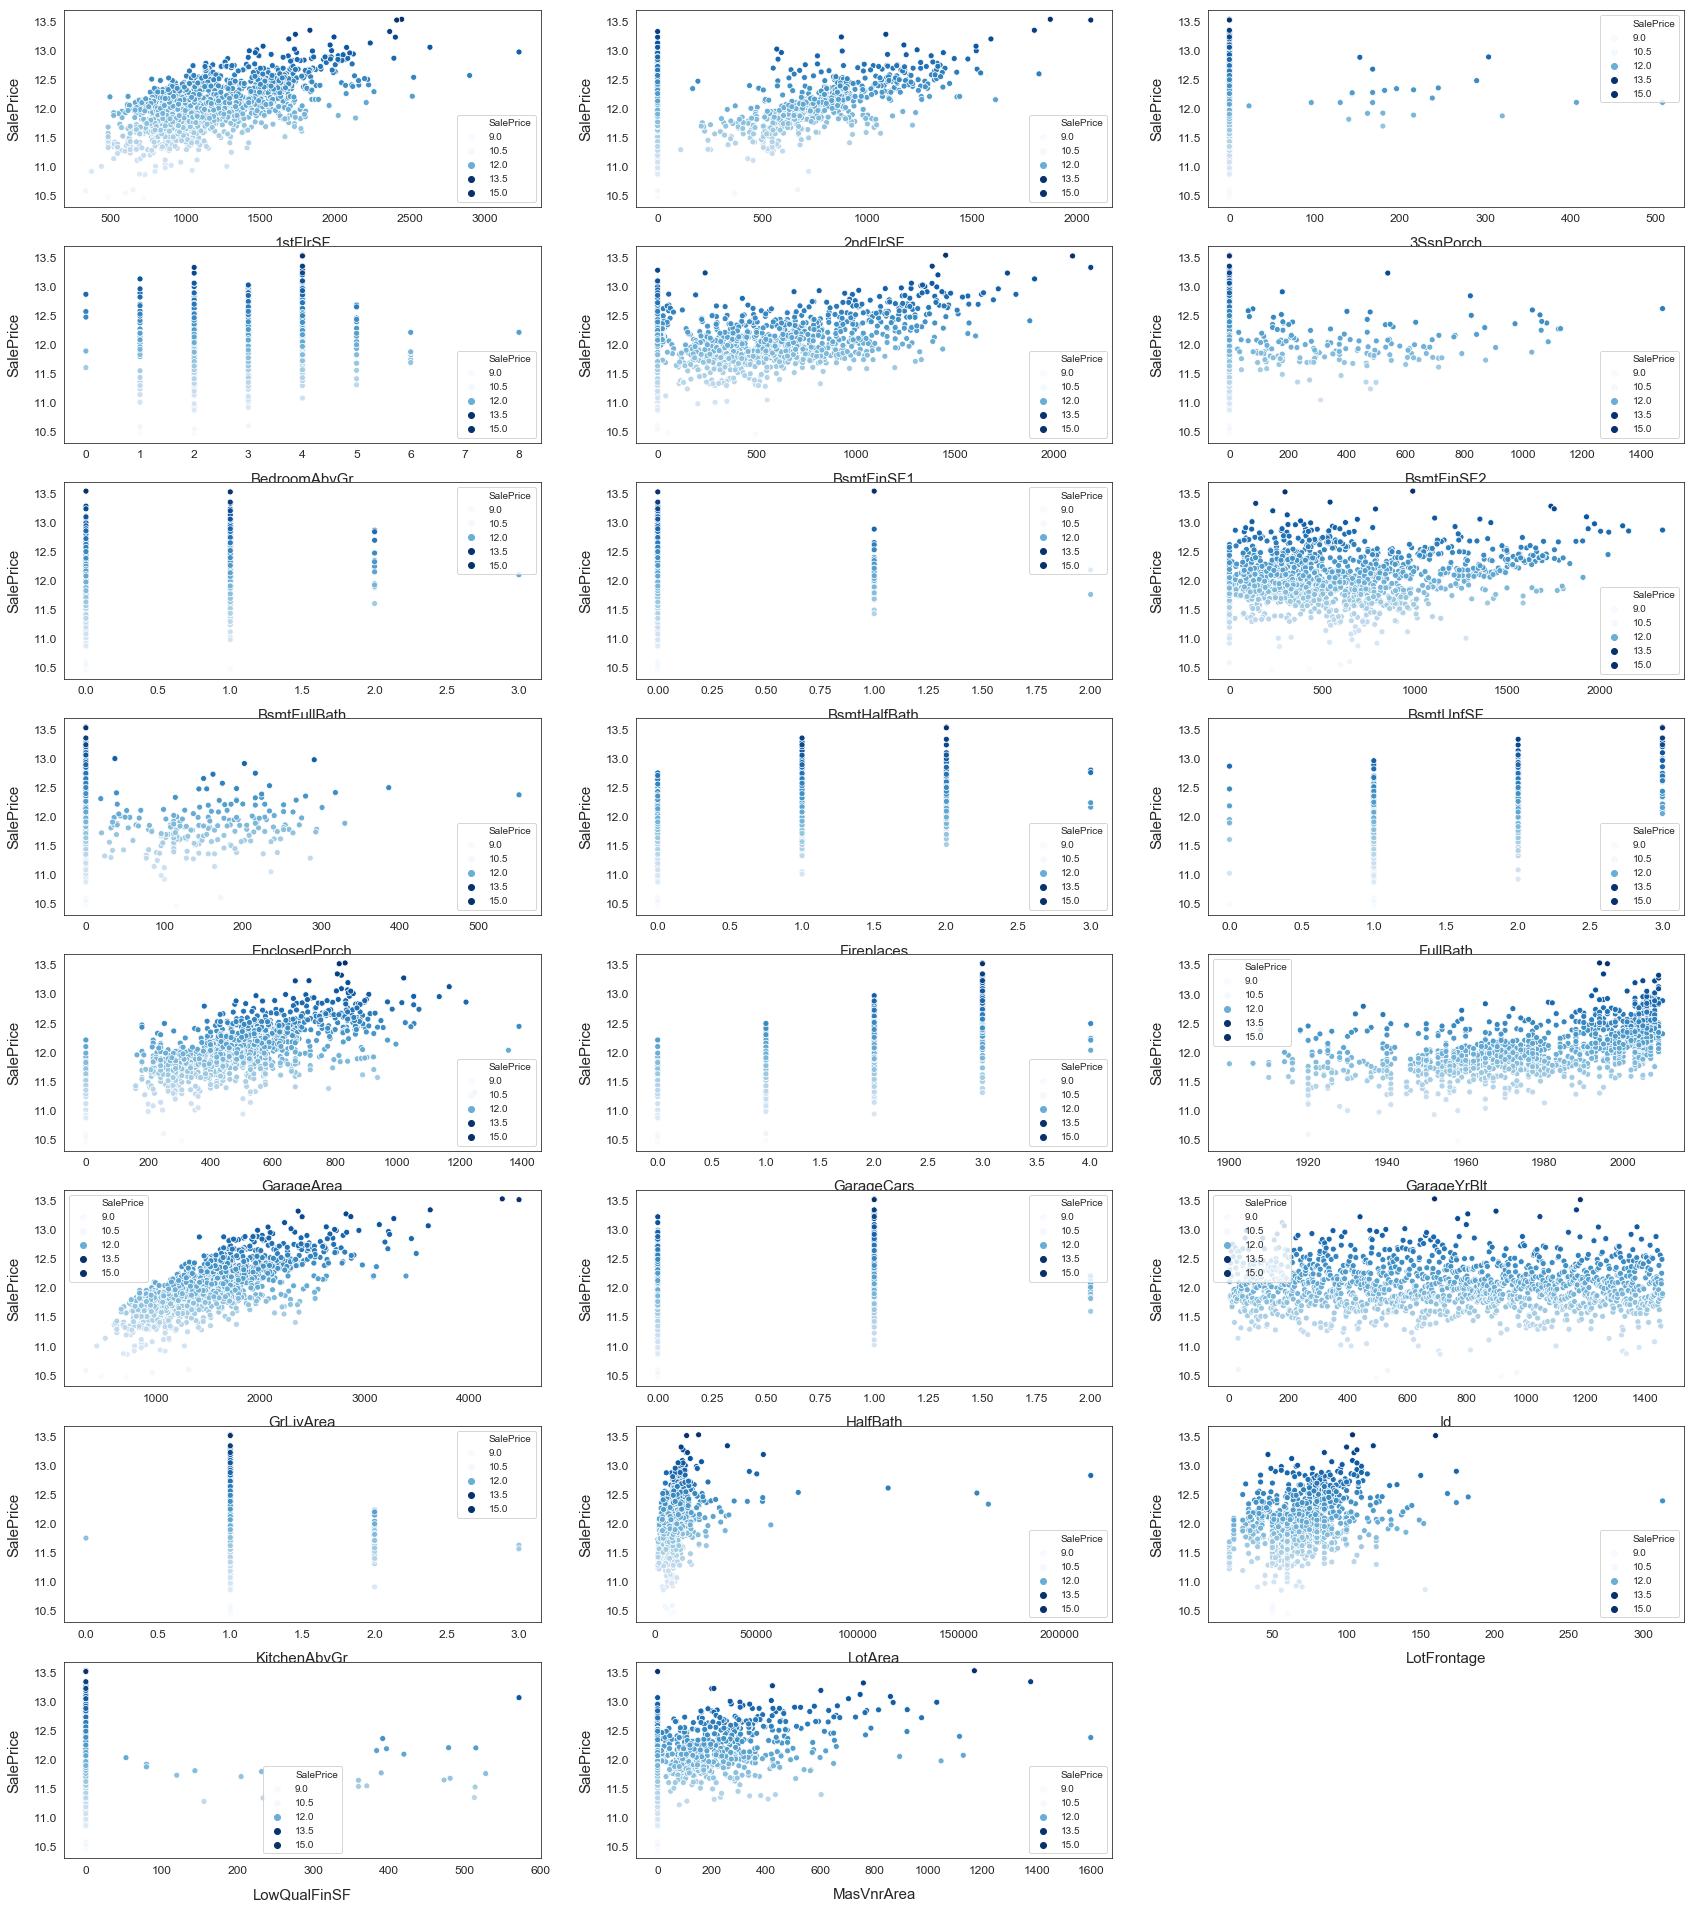

In [250]:
# Finding numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in X.columns:
    if X[i].dtype in numeric_dtypes:
        if i in ['TotalSF', 'Total_Bathrooms','Total_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
            pass
        else:
            numeric.append(i)     
# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 150))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)
for i, feature in enumerate(list(X[numeric]), 1):
    if(feature=='MiscVal'):
        break
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Blues', data=train)
        
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.show()

In [255]:
print("""
Train a model

Key features of the model training process:
Cross Validation: Using 12-fold cross-validation
Models: On each run of cross-validation I fit 7 models (ridge, svr, gradient boosting, random forest, xgboost, lightgbm regressors)
Stacking: In addition, I trained a meta StackingCVRegressor optimized using xgboost
Blending: All models trained will overfit the training data to varying degrees. Therefore, to make final predictions,
I blended their predictions together to get more robust predictions.

Setup cross validation and define error metrics

""")


Train a model

Key features of the model training process:
Cross Validation: Using 12-fold cross-validation
Models: On each run of cross-validation I fit 7 models (ridge, svr, gradient boosting, random forest, xgboost, lightgbm regressors)
Stacking: In addition, I trained a meta StackingCVRegressor optimized using xgboost
Blending: All models trained will overfit the training data to varying degrees. Therefore, to make final predictions,
I blended their predictions together to get more robust predictions.

Setup cross validation and define error metrics




In [256]:
# Setup cross validation folds
kf = KFold(n_splits=12, random_state=42, shuffle=True)

In [258]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
     # k折交叉验证
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf)) 
    return (rmse)

In [259]:
#Setup models

In [260]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression',  #线性回归
                       num_leaves=6, # 每颗树6个叶子
                       learning_rate=0.01, 
                       n_estimators=7000, #训练7000颗树
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000, # 6000棵树
                       max_depth=4, # 最大深度为4
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',  # 线性回归
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

In [262]:
?RobustScaler # 有较多异常值的情况下, 不适合减均值除标准差,需要用RobustScaler先变换

In [266]:
# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
# 有较多异常值的情况下, 不适合减均值除标准差,需要用RobustScaler先变换
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf)) #岭回归( 平方正则)

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000, # 6000棵树
                                learning_rate=0.01,
                                max_depth=4,  #  树的最大深度
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200, # 1200棵树
                          max_depth=15, #  树的最大深度
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
                                meta_regressor=xgboost, # 第二层的元学习器为 xgboost
                                use_features_in_secondary=True)

In [273]:
"""
Train models

Get cross validation scores for each model

单独使用lightgbm k 折交叉验证训练, 看看各个模型的预测分数为多少,用于查看各个模型的预测表现
"""

'\nTrain models\n\nGet cross validation scores for each model\n\n单独使用lightgbm k 折交叉验证训练, 看看各个模型的预测分数为多少,用于查看各个模型的预测表现\n'

In [271]:
scores = {}
# 单独使用lightgbm k 折交叉验证训练, 看看各个模型的预测分数为多少,用于查看各个模型的预测表现
score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))  # k折的方差与均值
scores['lgb'] = (score.mean(), score.std())

lightgbm: 0.0451 (0.0163)


In [269]:
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

xgboost: 0.0452 (0.0130)


In [278]:
score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

SVR: 0.0205 (0.0087)


In [279]:
scores

{'lgb': (0.0450791200147645, 0.016337655151758116),
 'svr': (0.020521436757431552, 0.008656292953174905)}

In [280]:
score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

ridge: 0.0000 (0.0000)


In [ ]:
score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

rf: 0.0168 (0.0120)


In [ ]:
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

In [ ]:
"""
使用stack模型拟合
Fit the models
"""

In [ ]:
"""
使用7个模型进行stack,这次是使用所有的数据,而非k折交叉了
"""
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(train_labels))

In [ ]:
print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, train_labels)

In [ ]:
print('xgboost')
xgb_model_full_data = xgboost.fit(X, train_labels)


In [ ]:
print('Svr')
svr_model_full_data = svr.fit(X, train_labels)

In [ ]:
print('Ridge')
ridge_model_full_data = ridge.fit(X, train_labels)

In [ ]:
print('RandomForest')
rf_model_full_data = rf.fit(X, train_labels)

In [ ]:
print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, train_labels)

In [ ]:
#Blend models and get predictions

In [ ]:
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(X):
    return ((0.1 * ridge_model_full_data.predict(X)) + \
            (0.2 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.1 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.05 * rf_model_full_data.predict(X)) + \
            (0.35 * stack_gen_model.predict(np.array模 #  stack模型给了最高的权重

In [ ]:
# Get final precitions from the blended model
blended_score = rmsle(train_labels, blended_predictions(X))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

In [ ]:
# Identify the best performing model

In [ ]:
# Plot the predictions for each model
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

In [ ]:
""" 
We can observe from the graph above that the blended
model far outperforms the other models, with an RMSLE of 0.075. 

This is the model I'll use for making the final predictions. 
"""

In [ ]:
# Submit predictions

In [275]:
# Read in sample_submission dataframe
submission = pd.read_csv("input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission.shape

(1459, 2)

In [276]:
submission.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [274]:
# Append predictions from blended models
submission.iloc[:,1] = np.floor(np.expm1(blended_predictions(X_test))) # 使用exp(x) -1 将我们转换后的价格真实数值恢复

NameError: name 'blended_predictions' is not defined

In [ ]:
# Fix outleir predictions 
q1 = submission['SalePrice'].quantile(0.0045) #  0.0045分位点
q2 = submission['SalePrice'].quantile(0.99)  # 99%分位点
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv("submission_regression1.csv", index=False)

In [277]:
# Scale predictions
submission['SalePrice'] *= 1.001619  # 将最终预测的值进行了缩放
submission.to_csv("submission_regression2.csv", index=False)